## Importing the relevant packages

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [2]:
url = './ignore/S3/L11/Index2018.csv'
raw_csv_data = pd.read_csv(url) 
df=raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index("date", inplace=True)
df=df.asfreq('b')
df=df.fillna(method='ffill')

In [3]:
df['market_value']=df.ftse

In [4]:
del df['spx']
del df['dax']
del df['ftse']
del df['nikkei']
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [5]:
# import warnings
# warnings.filterwarnings("ignore")

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [8]:
df_train['returns'] = df_train.market_value.pct_change(1)*100

/var/folders/2h/c7dkm6rj2w318lkvfrnrk2c00000gn/T/ipykernel_37996/3020228530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['returns'] = df_train.market_value.pct_change(1)*100


## Creating Squared Returns

In [12]:
df_train['sq_returns'] = df_train['returns'].mul(df_train['returns'])

/var/folders/2h/c7dkm6rj2w318lkvfrnrk2c00000gn/T/ipykernel_37996/3690060056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sq_returns'] = df_train['returns'].mul(df_train['returns'])


## Returns vs Squared Returns

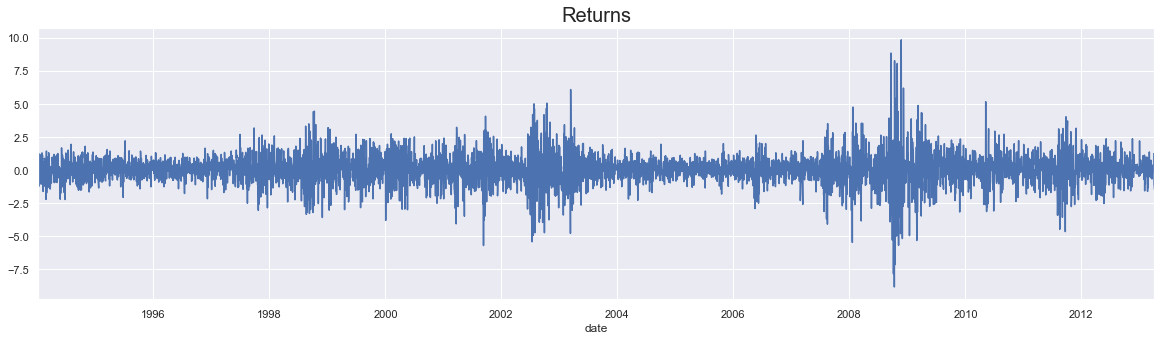

In [10]:
df_train['returns'].plot(figsize=(20,5))
plt.title("Returns", size=20)
plt.show()

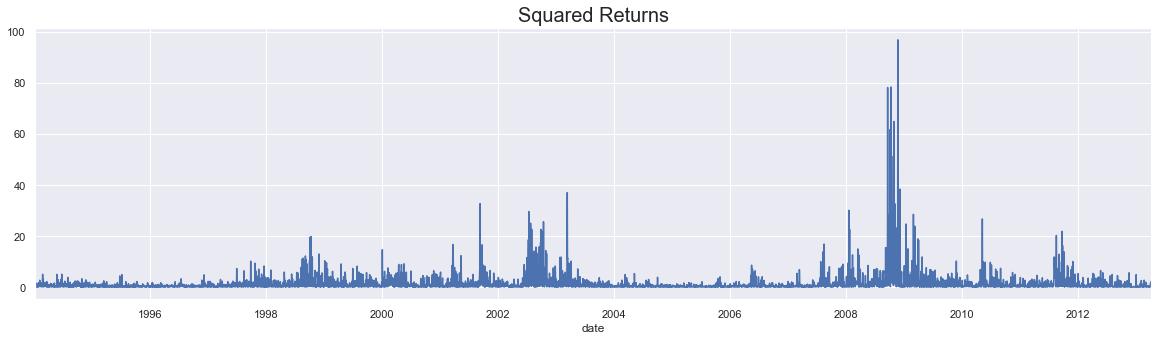

In [13]:
df_train['sq_returns'].plot(figsize=(20,5))
plt.title("Squared Returns", size=20)
plt.show()

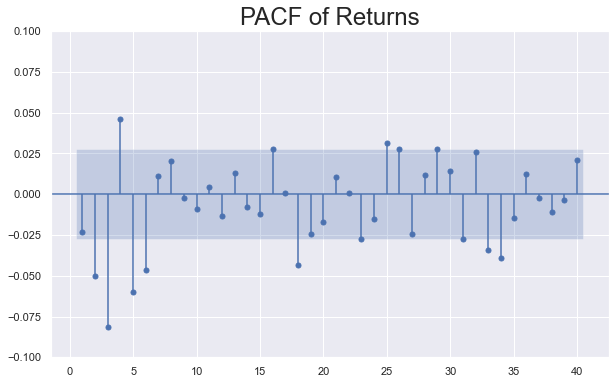

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
sgt.plot_pacf(df_train['returns'][1:], lags=40, zero=False, method='ols', ax=ax)
plt.title("PACF of Returns", size=24)
plt.ylim(-0.1, 0.1)
plt.show()

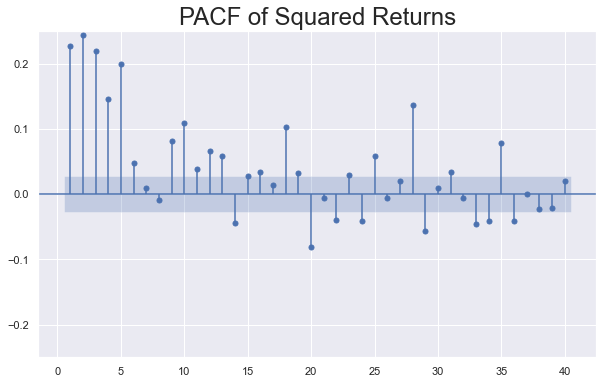

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
sgt.plot_pacf(df_train['sq_returns'][1:], lags=40, zero=False, method='ols', ax=ax)
plt.title("PACF of Squared Returns", size=24)
plt.ylim(-0.25, 0.25)
plt.show()

## The arch_model() Method

In [23]:
from arch import arch_model

In [31]:
arch1 = arch_model(df_train['returns'][1:], mean='constant', vol='ARCH', p=1)
results_arch1 = arch1.fit() #update_freq=5
print(results_arch1.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 29071.830522657772
Iteration:      2,   Func. Count:     13,   Neg. LLF: 12040.742295037046
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7809.722828039791
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7660.088789373729
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.088782041057
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7660.088782041088
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.088782041057
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC

In [37]:
# mean = "Constant", "Zero", "AR"
# lags = [1, 4, 5] (use when mean = "AR")
# dist = "t", "ged" #generalised error distribution

arch1 = arch_model(df_train['returns'][1:], mean='zero', vol='ARCH', p=1)
results_arch1 = arch1.fit() #update_freq=5
print(results_arch1.summary())

Iteration:      1,   Func. Count:      4,   Neg. LLF: 11616.486529800517
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7814.993275958137
Iteration:      3,   Func. Count:     15,   Neg. LLF: 7662.934735866603
Iteration:      4,   Func. Count:     18,   Neg. LLF: 7662.934731760531
Iteration:      5,   Func. Count:     20,   Neg. LLF: 7662.934731760544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7662.934731760531
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7662.93
Distribution:                  Normal   AIC:                           15329.9
Method:            Maximum Likelihood

### Engle Test (1982) to test for ARCH effects

In [32]:
from statsmodels.tsa.stattools import breakvar_heteroskedasticity_test

In [34]:
arma11 = ARIMA(df_train['returns'], order=(1,1,1))
results_arma11 = arma11.fit()

In [36]:
breakvar_heteroskedasticity_test(results_arma11.resid * results_arma11.resid)

(9.143342137148025, 0.0)

    The above results show that the second value (the p-value, is < 0.05. This allows us to reject the null hypothesis that )

## Higher-Lag ARCH Models

In [38]:
arch2 = arch_model(df_train['returns'][1:], mean='constant', vol='ARCH', p=2)
results_arch2 = arch2.fit() #update_freq=5
print(results_arch2.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34336.610580418666
Iteration:      2,   Func. Count:     15,   Neg. LLF: 11809.810549934296
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7900.589331450239
Iteration:      4,   Func. Count:     31,   Neg. LLF: 7647.101202993104
Iteration:      5,   Func. Count:     37,   Neg. LLF: 8810.009141231838
Iteration:      6,   Func. Count:     44,   Neg. LLF: 7449.5512008750575
Iteration:      7,   Func. Count:     49,   Neg. LLF: 7449.545177542658
Iteration:      8,   Func. Count:     54,   Neg. LLF: 7449.5451640981455
Iteration:      9,   Func. Count:     58,   Neg. LLF: 7449.545164098037
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7449.5451640981455
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                returns   R-squared:           

In [39]:
arch3 = arch_model(df_train['returns'][1:], mean='constant', vol='ARCH', p=3)
results_arch3 = arch3.fit() #update_freq=5
print(results_arch3.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 39962.460834752164
Iteration:      2,   Func. Count:     18,   Neg. LLF: 11954.637016280223
Iteration:      3,   Func. Count:     27,   Neg. LLF: 8336.666464005226
Iteration:      4,   Func. Count:     34,   Neg. LLF: 7489.939732969005
Iteration:      5,   Func. Count:     41,   Neg. LLF: 7496.407337070774
Iteration:      6,   Func. Count:     48,   Neg. LLF: 7393.754179234415
Iteration:      7,   Func. Count:     56,   Neg. LLF: 7301.714387363918
Iteration:      8,   Func. Count:     63,   Neg. LLF: 7277.05058117724
Iteration:      9,   Func. Count:     69,   Neg. LLF: 7277.050453150861
Iteration:     10,   Func. Count:     75,   Neg. LLF: 7277.050452148325
Iteration:     11,   Func. Count:     80,   Neg. LLF: 7277.050452148309
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7277.050452148325
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 1